This notebook focus on Actor-Critc and A2C

In [1]:
import os
# disable tensorflow logging
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import statistics
import numpy as np
import tensorflow as tf
import gym
import tqdm
import collections


2023-03-23 03:38:40.957729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 03:38:41.039227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 03:38:41.039243: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-23 03:38:41.420562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
class Env():
    def __init__(self, max_step=1000):
        self.env = gym.make("CartPole-v1")
        self.max_step = max_step
        self.cur_step = 1
        self.action_space = self.env.action_space
        
    def reset(self):
        self.cur_step = 1
        initial_state, info = self.env.reset()
        initial_state = self.add_step_into_state(initial_state)
        return initial_state, info
    
    def add_step_into_state(self, state):
#         state = np.concatenate([state, np.array([self.cur_step/self.max_step])])
        
        return state
    
    def step(self, action):
        self.cur_step += 1
        state, reward, done, _, _ = self.env.step(action)
        if self.cur_step > self.max_step:
            reward = 1.0
            done = True
            self.cur_step = self.max_step + 1
        else:
            if done:
                reward = 1.0
        state = self.add_step_into_state(state)
        return state, reward, done, _, _

In [3]:
env = gym.make("CartPole-v1")
# env = Env()
initial_state, _ = env.reset()
initial_state_shape = initial_state.shape
action_space = env.action_space.n
eps = np.finfo(np.float32).eps.item()
gamma = 0.99
lr = 0.01
step_length = 50


# define model

In [4]:
"""
The model will use basic Actor-Critc (A2C with baseline)
"""

def get_model():
    inputs = tf.keras.layers.Input(shape=initial_state_shape)
    hidden = tf.keras.layers.Dense(128, activation="relu")(inputs)
    actions = tf.keras.layers.Dense(action_space, activation=tf.keras.activations.softmax)(hidden)
    value = tf.keras.layers.Dense(1, activation=None)(hidden)
    outs = [actions, value]
    return tf.keras.Model(inputs, outs)

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          640         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            258         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 1)            129         ['dense[0][0]']                  
                                                                                              

2023-03-23 03:38:41.989520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 03:38:41.989713: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 03:38:41.989752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-23 03:38:41.989780: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-23 03:38:41.989805: W tensorflow/c

# define data collection

In [5]:
def _run_step_numpy(action):
    state, reward, done, _, _ = env.step(action)
    return (state.astype(np.float32), np.array(reward, dtype=np.float32), np.array(done, dtype=np.int32))

def run_step_tf(action):
    return tf.numpy_function(_run_step_numpy, [action], (tf.float32, tf.float32, tf.int32))

def run_step(start_state, model, step_length):

    values = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    actions = tf.TensorArray(tf.int32, size=0, dynamic_size=True)
    action_probs = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    done = tf.constant(True, dtype=tf.bool)
    done_shape = done.shape
    
    state = start_state
    for t in tf.range(step_length):
        action_output, value = model(tf.expand_dims(state, 0))
        action = tf.random.categorical(tf.math.log(action_output), num_samples=1, dtype=tf.int32)[0,0]   
        
        state, reward, done = run_step_tf(action)
        state.set_shape(initial_state_shape)
        
        actions = actions.write(t, action)
        values = values.write(t, tf.squeeze(value))
        rewards = rewards.write(t, reward)
        action_probs = action_probs.write(t, action_output[0, action])
        done = tf.cast(done, dtype=tf.bool)
        done.set_shape(done_shape)
        if done:
            break
    
    next_value = tf.constant(0.0, dtype=tf.float32)
    next_value_shape = next_value.shape
    if not done:
        _, next_value = model(tf.expand_dims(state, 0))
        next_value = tf.squeeze(next_value)
        next_value.set_shape(next_value_shape)
     
    actions = actions.stack()
    values = values.stack()
    action_probs = action_probs.stack()
    rewards = rewards.stack()
    return values, actions, action_probs, rewards, next_value, state, done

In [6]:
state_, _ = env.reset()
result = run_step(state_, model, 500)
values, actions, action_probs, rewards, next_value, state, done = result

/home/wei/anaconda3/envs/tf_211/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# define returns

In [7]:
def get_returns(rewards_array, gamma=0.99):
    """
    Input: total_rewards is a value
    Output: 
        discount_array: array of discount rate.
            index i to the (end timestamp + 1) discount rate
        returns: array of discounted returns
            index i means the returns between index i to the index(end timestamp + 1)
    """
    rewards_array = tf.squeeze(rewards_array)
    gamma = tf.constant(gamma, tf.float32)
    discounted_return = tf.constant(0.0, tf.float32)
    dshape = discounted_return.shape
    returns = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for idx in tf.range(tf.shape(rewards_array)[0] -1, -1, -1):
        discounted_return = gamma * discounted_return + rewards_array[idx]
        discounted_return.set_shape(dshape)
        returns = returns.write(idx, discounted_return)
    discount_array = tf.ones_like(rewards_array, dtype=tf.float32) * gamma
    discount_array = tf.math.cumprod(discount_array, reverse=True)
    returns = returns.stack()
    
    returns = (returns - tf.math.reduce_mean(returns)) / (eps + tf.math.reduce_std(returns))
    
    return discount_array, returns
 

In [8]:
rewards = result[3]
get_returns(rewards)

(<tf.Tensor: shape=(33,), dtype=float32, numpy=
 array([0.7177307 , 0.7249805 , 0.7323035 , 0.7397005 , 0.74717224,
        0.75471944, 0.7623429 , 0.7700433 , 0.77782154, 0.7856783 ,
        0.79361445, 0.80163074, 0.809728  , 0.8179071 , 0.8261688 ,
        0.8345139 , 0.8429433 , 0.8514579 , 0.8600585 , 0.8687459 ,
        0.8775211 , 0.88638496, 0.89533836, 0.90438217, 0.91351736,
        0.9227448 , 0.9320654 , 0.9414802 , 0.95099014, 0.9605961 ,
        0.97029907, 0.98010004, 0.99      ], dtype=float32)>,
 <tf.Tensor: shape=(33,), dtype=float32, numpy=
 array([ 1.59427   ,  1.5047258 ,  1.4142774 ,  1.3229153 ,  1.2306305 ,
         1.1374135 ,  1.0432549 ,  0.9481452 ,  0.8520746 ,  0.7550337 ,
         0.65701246,  0.55800134,  0.4579899 ,  0.35696834,  0.25492647,
         0.1518537 ,  0.04773988, -0.05742556, -0.16365334, -0.2709541 ,
        -0.37933874, -0.48881814, -0.5994034 , -0.7111056 , -0.8239361 ,
        -0.9379063 , -1.0530279 , -1.1693122 , -1.286771  , -1.405416

# Loss

In [9]:
loss_func = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
def calculate_loss(returns, values, action_probs, value_next, discount_array):
    """
    Policy part ---------
    V(St) = E(Q) = Pi(St, At1; theta) * Q(St, At1) + ...
    G denote gradient W.R.T theta
    
    
    G(V(St)) = G[Pi(St, At1; theta) * Q(St, At1) + ...]
                approximate= Pi(St, A1)* G(logpi(St, At1; theta) * Q) + ...  # chain rule G(logpi) = 1/pi * G(pi)
                = E[ G(logpi * Q) ] # Pi(St, A) is the PDF, so this is the expectation
              [1]  approximate= G(logpi * Q)  # monte carlo approximation
              [2]  = G(logpi * (Q - baseline))  where baseline can be V. This is the A2C
                  Qt can be approximate by Yt
              Yt = gamma^T * Q(T) + r + gamma*r + gamma^2*r + ...
              
    Critic Part TD learning -----------
    Qt = discounted_ovserved + QT
            
    """
    logpi = tf.math.log( tf.clip_by_value(action_probs, eps, 1.0))
    Yt = returns + discount_array * value_next

    
    # this is the negative gradient instead of loss
    loss_actor = - logpi * (Yt - values)
    loss_actor = tf.reduce_mean(loss_actor)
    # critic
    loss_critic = loss_func(tf.expand_dims(Yt, 1), tf.expand_dims(values,1))
    loss = loss_actor + loss_critic
    return loss, loss_actor, loss_critic#, abs(Yt - values)

In [10]:
values, actions, action_probs, rewards, next_value, state, done = result
discount_array, returns_array = get_returns(rewards, gamma)
calculate_loss(returns_array, values, action_probs, next_value, discount_array)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0076962>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.04503724>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0527334>)

# train step

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

@tf.function
def run_train_step(model, optimizer, start_state, step_length):
    with tf.GradientTape() as tape:
        STEP_RES = run_step(start_state, model, step_length)
        values, actions, action_probs, rewards, next_value, state, done = STEP_RES
        discount_array, returns_array = get_returns(rewards, gamma)
        loss, loss_actor, loss_critic = calculate_loss(returns_array, values, action_probs, next_value, discount_array)
    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    return STEP_RES, loss, loss_actor, loss_critic

In [12]:
_state, _ = env.reset()
run_train_step(model, optimizer, _state, 50)

((<tf.Tensor: shape=(35,), dtype=float32, numpy=
  array([0.0096665 , 0.02728885, 0.01036417, 0.02908169, 0.06348184,
         0.03162865, 0.0110121 , 0.0349273 , 0.05697164, 0.03198292,
         0.0546873 , 0.03003553, 0.05301316, 0.075903  , 0.05130396,
         0.07472945, 0.05041291, 0.07425177, 0.05014359, 0.02514842,
         0.0515447 , 0.026605  , 0.00476238, 0.0181648 , 0.00381812,
         0.03101749, 0.00463236, 0.00285319, 0.00681384, 0.03491031,
         0.0079058 , 0.03602284, 0.05976458, 0.03540958, 0.0088207 ],
        dtype=float32)>,
  <tf.Tensor: shape=(35,), dtype=int32, numpy=
  array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
         0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0], dtype=int32)>,
  <tf.Tensor: shape=(35,), dtype=float32, numpy=
  array([0.50536966, 0.5076576 , 0.5043843 , 0.49111578, 0.52564263,
         0.51064306, 0.49787328, 0.50108266, 0.4943949 , 0.5000306 ,
         0.49568292, 0.49869496, 0.5030301 , 0.4933502 , 0.5005127 ,


# RUN

In [13]:
min_epoch = 100
max_epoch = 10000
step_length = 50
thred = 475
running_rewards = collections.deque(maxlen=100)
max_steps_per_epoch = 500
all_rewards = []
all_running_rewards = []
t = tqdm.trange(max_epoch)
for i in t:
    restart = False
    start_state, _ = env.reset()
    cur_step = 0
    epoch_reward = 0
    while cur_step < max_steps_per_epoch:
        try:
            STEP_RES, loss, loss_actor, loss_critic = run_train_step(model, optimizer, start_state, step_length)
        except Exception as e:
            restart = True
            break
        cur_step += step_length
        values, actions, action_probs, rewards, next_value, state, done = STEP_RES
        epoch_reward += int(sum(rewards))
        if done:
            break
    if restart:
        continue
    running_rewards.append(epoch_reward)
    avg_reward = statistics.mean(running_rewards)
    all_rewards.append(epoch_reward)
    all_running_rewards.append(avg_reward)
    t.set_postfix(running_rewards=avg_reward, current_reward=epoch_reward, loss=float(loss))
    if avg_reward > thred and i > min_epoch:
        break
    
    


  4%|▍         | 435/10000 [01:20<29:22,  5.43it/s, current_reward=500, loss=0.507, running_rewards=478] 


In [14]:
##
"""
no normalization
(1) 663/10000 [02:34<36:16,  4.29it/s, current_reward=1000, loss=409, running_rewards=482]  
(2) 491/10000 [03:25<1:06:16,  2.39it/s, current_reward=392, loss=916, running_rewards=476] 
(3) 511/10000 [03:54<1:12:42,  2.18it/s, current_reward=1000, loss=745, running_rewards=479]
(4) 658/10000 [04:02<57:26,  2.71it/s, current_reward=1000, loss=634, running_rewards=480]

with normalization
SUM
(1) 7%|▋         | 679/10000 [05:48<1:19:49,  1.95it/s, current_reward=500, loss=488, running_rewards=476]   

MEAN
(1) 519/10000 [04:35<1:23:46,  1.89it/s, current_reward=500, loss=0.655, running_rewards=476]  
(2) 4%|▍         | 390/10000 [03:22<1:23:05,  1.93it/s, current_reward=405, loss=0.0921, running_rewards=476] 
(3) 5%|▌         | 513/10000 [04:25<1:21:57,  1.93it/s, current_reward=500, loss=1.05, running_rewards=477]   


MEAN + modify last rewards
(1) 2%|▏         | 226/10000 [01:36<1:09:17,  2.35it/s, current_reward=598, loss=-.0738, running_rewards=475] 
(2) 3%|▎         | 294/10000 [01:36<53:09,  3.04it/s, current_reward=598, loss=-.0559, running_rewards=477]   
"""

# old env


'\nno normalization\n(1) 663/10000 [02:34<36:16,  4.29it/s, current_reward=1000, loss=409, running_rewards=482]  \n(2) 491/10000 [03:25<1:06:16,  2.39it/s, current_reward=392, loss=916, running_rewards=476] \n(3) 511/10000 [03:54<1:12:42,  2.18it/s, current_reward=1000, loss=745, running_rewards=479]\n(4) 658/10000 [04:02<57:26,  2.71it/s, current_reward=1000, loss=634, running_rewards=480]\n\nwith normalization\nSUM\n(1) 7%|▋         | 679/10000 [05:48<1:19:49,  1.95it/s, current_reward=500, loss=488, running_rewards=476]   \n\nMEAN\n(1) 519/10000 [04:35<1:23:46,  1.89it/s, current_reward=500, loss=0.655, running_rewards=476]  \n(2) 4%|▍         | 390/10000 [03:22<1:23:05,  1.93it/s, current_reward=405, loss=0.0921, running_rewards=476] \n(3) 5%|▌         | 513/10000 [04:25<1:21:57,  1.93it/s, current_reward=500, loss=1.05, running_rewards=477]   \n\n\nMEAN + modify last rewards\n(1) 2%|▏         | 226/10000 [01:36<1:09:17,  2.35it/s, current_reward=598, loss=-.0738, running_rewards=4

In [15]:
from matplotlib import pyplot as plt

In [16]:
_state, _ = env.reset()
result = run_step(_state, model, 1000)
values, actions, action_probs, rewards, next_value, state, done = result

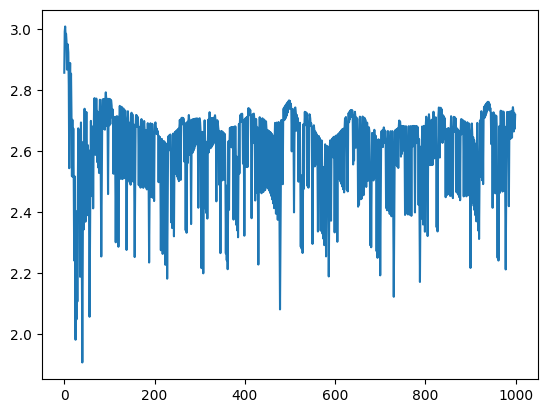

In [17]:
plt.plot(range(len(values)), values)

In [18]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("CartPole-v1", render_mode='rgb_array')

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  state, info = env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  images = [Image.fromarray(screen)]
  values = []

  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, value = model(state)
    #option 1
    action = np.argmax(np.squeeze(action_probs))
    #option 2
#     action = tf.random.categorical(tf.math.log(action_probs), num_samples=1, dtype=tf.int32)[0,0]   
#     action = action.numpy()
    values.append(tf.squeeze(value))

    state, reward, done, truncated, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render()
      images.append(Image.fromarray(screen))

    if done:
      break

  return images, values


# Save GIF image
images,values = render_episode(render_env, model, max_steps_per_epoch)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


/home/wei/anaconda3/envs/tf_211/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



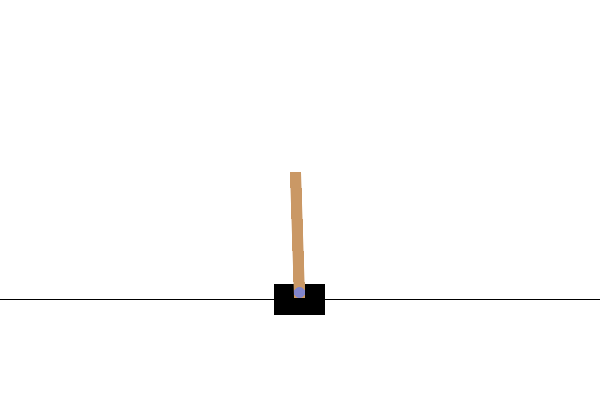

In [19]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

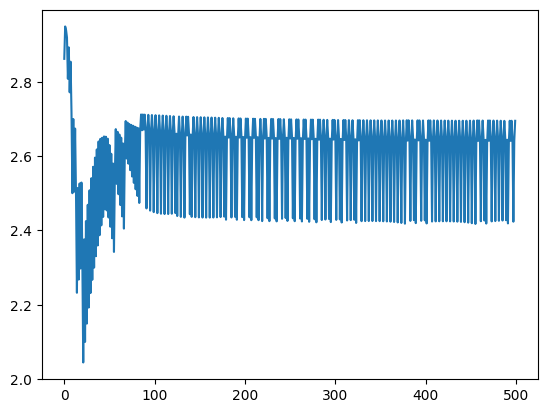

In [20]:
values = tf.stack(values)
values = values.numpy()
plt.plot(range(len(values)), values)